# Prévision des prix des voitures

### 1.4 Importation de bibliothèques

In [1]:
import re
import os
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns

import mlflow
import mlflow.tensorflow
from mlflow.models import infer_signature
from mlflow.models import ModelSignature
from mlflow.tensorflow import MlflowCallback

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, Dense, Input, ReLU, Dropout, InputLayer
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
import keras_tuner as kt

import matplotlib.pyplot as plt

from src.utils.preprocessing.feactures_selection import cols_correlations

print(tf.__version__)

2024-10-30 01:05:49.160692: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.2


### MlFlow Tracking

In [2]:
POSTGRES_HOST = "modele-pfe"
POSTGRES_DB = "pfe-database-monitoring"
POSTGRES_PASSWORD = "admin"
POSTGRES_USER = "Admin123"
POSTGRES_PORT = 5432

uri = 'postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}'

####  Configure MLflow

In [3]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:9000"
os.environ["AWS_ACCESS_KEY_ID"] = "minioAdmin"
os.environ["AWS_SECRET_ACCESS_KEY"] = "Adminminio2024"

In [4]:
# Configure MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("vehicle_prediction_tensorflow")
# Définir l'emplacement du stockage des artefacts
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

2024/10/30 01:08:09 INFO mlflow.tracking.fluent: Experiment with name 'vehicle_prediction_tensorflow' does not exist. Creating a new experiment.


tracking URI: 'http://localhost:5000'


### Parametres

In [5]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1
TEST_RATIO =0.2
EURO_PARITY = 667,96

### Definition fonction

In [6]:
def clean_numeric_string(value):
    """
    Supprime tous les caractères non numériques d'une chaîne de caractères.
    Si la chaîne devient vide après le nettoyage, retourne NaN.
    """
    # Supprimer tous les caractères non numériques, sauf les points (pour les flottants)
    cleaned_value = re.sub(r'[^\d.]+', '', str(value))

    # Si après le nettoyage la chaîne est vide, retourner NaN
    return float(cleaned_value) if cleaned_value else float('nan')

def convert_columns_to_int(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = df[col].apply(clean_numeric_string)
            df[col] = df[col].fillna(0).astype(float).astype(int)
    return df

def convert_prices_to_cfa(dataframe: pd.DataFrame, col_name: str = 'Prix', parity: float = 667.66):
    """
    Convertit les prix d'une colonne donnée en CFA en utilisant un taux de conversion spécifique.
    
    :param dataframe: Le DataFrame à modifier.
    :param col_name: Le nom de la colonne à convertir. Par défaut, 'Prix'.
    :param parity: Le taux de conversion Euro vers CFA. Par défaut, 655.957.
    :return: Le DataFrame modifié avec les prix convertis.
    """
    if col_name in dataframe.columns:
        # Convertir les prix en CFA et arrondir à l'entier le plus proche
        dataframe[col_name] = (dataframe[col_name] * parity).round().astype(int)
    return dataframe


def one_hot_encode(dataframe: pd.DataFrame, cols: list):
    """
    Encodes specified categorical columns in the DataFrame using one-hot encoding.

    Args:
        dataframe (pd.DataFrame): The DataFrame to encode.
        cols (list): List of column names to encode.

    Returns:
        pd.DataFrame: The DataFrame with one-hot encoded columns.
    """
    df_encoded = pd.get_dummies(dataframe, columns=cols, drop_first=True)
    return df_encoded

def label_encode(dataframe: pd.DataFrame, cols: list):
    """
    Encodes specified categorical columns in the DataFrame using label encoding.

    Args:
        dataframe (pd.DataFrame): The DataFrame to encode.
        cols (list): List of column names to encode.

    Returns:
        pd.DataFrame: The DataFrame with label encoded columns.
    """
    df_encoded = dataframe.copy()
    for col in cols:
        if col in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    return df_encoded

### 1.5 Chargement des données

In [7]:
path = '../data/cleaning/models/prepared_data_model.csv'
df_raw = pd.read_csv(path)

In [8]:
df = df_raw.copy()
df.head(10)

,Marque,Modele,Annee,Prix,Immatriculation,Vitesse_maximale,0_a_100_km/h,Cylindree,Au_regime_de,Couple_maxi,...,longueur,largeur,hauteur,empattement,reservoir,porte_a_faux_avant,porte_a_faux_arriere,voies_avant,voies_arriere,garde_au_sol
0,2.819009e+07,2.819009e+07,3.095923e+07,55075273,7e546927-d3e3-477f-8971-b0cd70187264,160.0,8.60,2998.0,4750.0,450.0,...,4.900,1.93,2.050,2.920,90.0,0.8870,0.8740,1.645,1.645,264.0
1,3.341498e+07,2.753632e+07,1.729196e+07,24613286,fb2f74bc-f6e0-4624-967c-78d9466accfa,235.0,9.20,2597.0,4500.0,240.0,...,4.520,1.72,1.430,2.720,62.0,1.0038,1.1132,1.500,1.470,141.0
2,4.403130e+07,2.642971e+07,1.754328e+07,27841422,cab0aab1-ba72-4778-b7f4-d1efaa37d5a9,230.0,8.50,2720.0,1900.0,435.0,...,4.910,1.82,1.450,2.910,70.0,0.9508,1.0888,1.534,1.542,143.0
3,3.475627e+07,3.862237e+07,1.846534e+07,29377040,0285f39e-16ab-410d-939c-37de56206408,245.0,7.10,2979.0,3500.0,300.0,...,4.840,1.85,1.470,2.890,70.0,0.8404,1.0444,1.558,1.582,158.6
4,1.704447e+07,2.258660e+07,1.789735e+07,12418476,3ea13155-3031-4ade-836f-c72c593b671c,170.0,12.50,1686.0,2300.0,240.0,...,4.320,1.68,1.800,2.720,52.0,0.8314,0.7984,1.417,1.440,125.6
5,3.489149e+07,2.507237e+07,2.184668e+07,24436356,0937655d-3cb1-4311-a657-c8fd974daa63,205.0,10.20,2231.0,3600.0,340.0,...,4.590,1.80,1.440,2.730,65.0,0.8200,1.0350,1.535,1.535,180.2
6,1.740768e+07,1.930159e+07,2.275957e+07,18894778,31e0569c-600e-46cb-8f91-45c525e89821,180.0,12.50,1461.0,1750.0,240.0,...,4.370,1.85,1.640,2.700,60.0,0.8850,0.7570,1.545,1.547,120.0
7,1.658521e+07,1.721114e+07,1.846534e+07,15489712,0e6a4256-8917-42b3-bfdf-84c419f3f429,188.0,11.80,1997.0,1750.0,250.0,...,4.200,1.75,1.510,2.610,60.0,0.8780,0.7160,1.497,1.502,147.2
8,6.922408e+06,2.152887e+07,2.017001e+07,5880749,105a5377-e006-4fc2-85f3-21b4c566ca78,160.8,14.72,690.0,6100.0,80.6,...,2.128,0.82,1.142,1.484,12.4,0.7492,0.6386,1.409,1.383,199.0
9,2.158674e+07,2.332600e+07,3.087770e+07,25905208,cc2a91d6-c28b-4997-b885-a71f2c6c019c,192.0,10.80,1496.0,4000.0,270.0,...,4.270,1.80,1.440,2.670,48.0,0.8010,0.7950,1.564,1.565,141.0


In [9]:
df.shape

(6310, 73)

### 1.6 Data Preprocessing

In [10]:
df.isnull().sum()

Marque                  0
Modele                  0
Annee                   0
Prix                    0
Immatriculation         0
                       ..
porte_a_faux_avant      0
porte_a_faux_arriere    0
voies_avant             0
voies_arriere           0
garde_au_sol            0
Length: 73, dtype: int64

In [11]:
df = df[cols_correlations]
df.head()

,Prix,Marque,Modele,Annee,puissance_commerciale,puissance_fiscale,emission_de_co2,boite_de_vitesses_Manuelle,carrosserie,longueur,...,Injection,Disposition_du_moteur,Puissance_reelle_maxi_ch,Boite_de_vitesses,Mode_de_transmission,Vitesse_maximale,Mixte,Emission_de_CO2,Cycle_urbain,Extra_urbain
0,55075273,2.819009e+07,2.819009e+07,3.095923e+07,286.0,0.0,325.0,0.0,3.089136e+07,4.90,...,3.146036e+07,3.828318e+07,4.580941e+07,3.678985e+07,3.537250e+07,160.0,14.4,325.0,13.46,7.48
1,24613286,3.341498e+07,2.753632e+07,1.729196e+07,157.4,12.0,148.6,1.0,3.278531e+07,4.52,...,1.894061e+07,3.828318e+07,2.860719e+07,2.420237e+07,3.386491e+07,235.0,10.8,259.0,16.00,7.80
2,27841422,4.403130e+07,2.642971e+07,1.754328e+07,167.2,13.0,161.8,1.0,3.278531e+07,4.91,...,2.668097e+07,3.828318e+07,2.471728e+07,2.420237e+07,3.386491e+07,230.0,7.1,189.0,9.70,5.70
3,29377040,3.475627e+07,3.862237e+07,1.846534e+07,169.6,15.0,199.0,0.0,3.278531e+07,4.84,...,1.894061e+07,3.828318e+07,3.103949e+07,2.929526e+07,3.386491e+07,245.0,9.9,245.0,14.20,7.50
4,12418476,1.704447e+07,2.258660e+07,1.789735e+07,88.4,6.0,140.0,1.0,1.720609e+07,4.32,...,2.668097e+07,2.168137e+07,1.370729e+07,1.406516e+07,1.947041e+07,170.0,5.2,140.0,6.60,4.40


#### Convertir le prix véhicule en CFA

#### Validate et determination anciente vehicule

In [13]:
# df['Annee'] = pd.to_numeric(df['Annee'], errors='coerce')
# df['Age_Vehicule'] = 2024 - df['Annee']
# df.drop(['Annee'], inplace=True, axis=1)
# df.head(10)

In [13]:
data_cleaned = df.copy()

In [14]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6310 entries, 0 to 6309
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Prix                        6310 non-null   int64  
 1   Marque                      6310 non-null   float64
 2   Modele                      6310 non-null   float64
 3   Annee                       6310 non-null   float64
 4   puissance_commerciale       6310 non-null   float64
 5   puissance_fiscale           6310 non-null   float64
 6   emission_de_co2             6310 non-null   float64
 7   boite_de_vitesses_Manuelle  6310 non-null   float64
 8   carrosserie                 6310 non-null   float64
 9   longueur                    6310 non-null   float64
 10  largeur                     6310 non-null   float64
 11  empattement                 6310 non-null   float64
 12  reservoir                   6310 non-null   float64
 13  porte_a_faux_avant          6310 

## 1.7 Data Preparation

#### 1.7.1 Features Extraction

In [15]:
# Séparation des caractéristiques (features) et de la cible (target)
X = data_cleaned.drop(columns=['Prix'])
y = data_cleaned['Prix']

In [16]:
y.shape

(6310,)

In [17]:
from sklearn.model_selection import train_test_split

# Mélanger les données avant la division
X, y = shuffle(X, y, random_state=100)

# Séparation des données en ensembles d'entraînement, de validation et de test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((4417, 41), (4417,), (947, 41), (947,), (946, 41), (946,))

## 1.8 Normalizing

In [19]:
# from sklearn.preprocessing import StandardScaler
# 
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_test)

In [20]:
# from sklearn.preprocessing import MinMaxScaler
# 
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_test)

#### 1.7.2 Data Pipeline Components
- Création du Dataset 
- Mélange des Données
- Division en Mini-lots
- Préchargement

In [18]:
def create_data_pipeline(X, y, batch_size=32, buffer_size=8):
    """
    Crée un pipeline de données TensorFlow avec les étapes de prétraitement standard.

    Args:
        X (tf.Tensor or np.array): Données d'entrée.
        y (tf.Tensor or np.array): Étiquettes cibles.
        normalizer (tf.keras.layers.Normalization, optional): Objet de normalisation à appliquer.
        batch_size (int): Taille des mini-lots.
        buffer_size (int): Taille du tampon pour le mélange des données.

    Returns:
        tf.data.Dataset: Pipeline de données prêt à être utilisé pour l'entraînement.
    """
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    dataset = dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

#### 1.7.3 Data Encoding |  Encodage Label

In [22]:
# numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
# categorical_cols = X.select_dtypes(include=['object']).columns

In [23]:
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# 
# # Création d'un pipeline d'encodage pour les colonnes catégorielles
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat_transform', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
#     ], remainder='passthrough')
# 
# pipe = Pipeline(
#     [
#         ('col_tranform', preprocessor),
#         ('standard_scaler', StandardScaler(with_mean=False))
#     ])

In [24]:
# # Appliquer le préprocesseur sur les données d'entraînement, validation, et test
# X_train_processed = pipe.fit_transform(X_train)
# X_val_processed = pipe.transform(X_val)      
# X_test_processed = pipe.transform(X_test)

In [25]:
# # Convertir en tableau dense
# X_train_dense = X_train_processed.toarray()
# X_val_dense = X_val_processed.toarray()
# X_test_dense = X_test_processed.toarray()

#### 1.7.4 Converti en un objet tf.Tensor de TensorFlow

In [20]:
# Conversion des features en tenseurs TensorFlow
X_train_tf = tf.constant(X_train, dtype=tf.float32)
X_val_tf = tf.constant(X_val, dtype=tf.float32)
X_test_tf = tf.constant(X_test, dtype=tf.float32)

# Conversion des étiquettes (Prix ici) en tenseurs TensorFlow
y_train_tf = tf.constant(y_train, dtype=tf.float32)
y_val_tf = tf.constant(y_val, dtype=tf.float32)
y_test_tf = tf.constant(y_test, dtype=tf.float32)

# Ajustement de la dimension si nécessaire
y_train_tf = tf.expand_dims(y_train_tf, axis=1)
y_val_tf = tf.expand_dims(y_val_tf, axis=1)
y_test_tf = tf.expand_dims(y_test_tf, axis=1)

In [21]:
y_train_tf_log = tf.math.log(y_train_tf + 1)
y_val_tf_log = tf.math.log(y_val_tf + 1)
y_test_tf_log = tf.math.log(y_test_tf + 1)

In [22]:
X_train_tf[:5]

<tf.Tensor: shape=(5, 41), dtype=float32, numpy=
array([[1.5242921e+07, 1.3283420e+07, 2.7236480e+07, 9.5000000e+01,
        5.0000000e+00, 1.1800000e+02, 1.0000000e+00, 1.5662558e+07,
        4.0599999e+00, 1.7800000e+00, 2.5599999e+00, 4.0000000e+01,
        7.9600000e-01, 6.9900000e-01, 1.5250000e+00, 1.1280000e+03,
        1.6400000e+03, 2.6400000e+03, 1.0000000e+03, 5.6000000e+02,
        2.8948644e+07, 1.5734600e+07, 1.5814024e+07, 9.9900000e+02,
        1.7500000e+02, 1.2000000e+01, 7.0000000e+01, 7.4500000e+01,
        7.6400002e+01, 1.6131529e+07, 2.5432240e+07, 3.1460360e+07,
        2.1681372e+07, 1.4827865e+07, 1.4065158e+07, 1.9470410e+07,
        1.8600000e+02, 4.5799999e+00, 1.1800000e+02, 5.9600000e+00,
        3.8199999e+00],
       [2.0387486e+07, 2.2893750e+07, 2.2652442e+07, 1.2320000e+02,
        1.0000000e+01, 1.4400000e+02, 1.0000000e+00, 1.5662558e+07,
        4.4600000e+00, 1.7600000e+00, 2.6400001e+00, 5.5000000e+01,
        8.2620001e-01, 7.7620000e-01, 1.530

In [23]:
# Créer la couche de normalisation
normalizer = tf.keras.layers.Normalization(axis=-1)
# Adapter la normalisation aux données d'entraînement
normalizer.adapt(X_train_tf)

In [24]:
y_train_tf.shape

TensorShape([4417, 1])

In [25]:
y_train_tf[:5, :]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[12919221.],
       [17325776.],
       [30378530.],
       [24589918.],
       [23868176.]], dtype=float32)>

#### 1.7.5 Créez les pipelines de données

In [26]:
# Créez les pipelines de données
batch_size = 32
buffer_size = 1000

train_dataset = create_data_pipeline(X_train_tf, y_train_tf_log, batch_size=batch_size, buffer_size=buffer_size)
val_dataset = create_data_pipeline(X_val_tf, y_val_tf_log, batch_size=batch_size, buffer_size=buffer_size)
test_dataset = create_data_pipeline(X_test_tf, y_test_tf_log, batch_size=batch_size, buffer_size=buffer_size)

## 2. Build Model

### 2.1 Modele with normalizer

In [27]:
# Définition de la forme d'entrée en utilisant Input()
input_shape = (X_train_tf.shape[1],)

model = tf.keras.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(normalizer)
model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
layers.Dropout(0.2)
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
layers.Dropout(0.2)
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 41)             │            83 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,564 (267.83 KB)

 Trainable params: 68,481 (267.50 KB)

 Non-trainable params: 83 (336.00 B)

In [28]:
learning_rate = 0.0001
epochs = 10

In [29]:
# Compilation du modèle avec une perte de type Mean Squared Error (MSE) pour la régression
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='mean_squared_logarithmic_error',
              metrics=['mae'])

In [30]:
steps_per_epoch = len(X_train_tf) // batch_size
validation_steps = len(X_val_tf) // batch_size

In [ ]:
mlflow.tensorflow.autolog()
with mlflow.start_run(run_name="vehicle_predict_tensorflow") as run:
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=100,
        # steps_per_epoch=steps_per_epoch,
        # validation_steps=validation_steps,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

In [32]:
model.evaluate(X_test_tf, y_test_tf_log)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3668e-04 - mae: 0.1565 


[0.0001424841902917251, 0.16095459461212158]

In [33]:
y_pred_log = model.predict(X_test_tf)
y_pred = tf.exp(y_pred_log) - 1

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [34]:
y_pred_flat = y_pred[:10].numpy().ravel()
df = pd.DataFrame({'Valeur Prédite': y_pred_flat, 'Valeur Réelle': y_test[:10]})
df.head(10)

,Valeur Prédite,Valeur Réelle
2285,20305932.0,25537995
3583,34247656.0,34050660
588,5942553.0,7077196
4947,14678829.0,18260501
3070,14493185.0,16424436
1453,6136138.5,7340922
6269,12863194.0,14758624
4286,39310540.0,46990578
4402,14947174.0,18734540
4388,14941844.0,19295374


In [35]:
example_input = np.array(X_test_tf[:5])
example_output = np.array(y_pred[:5])

# Inférez la signature à partir des exemples d'entrée
signature = infer_signature(example_input, example_output)
mlflow.keras.log_model(model, "model_tennsorflow", signature=signature)

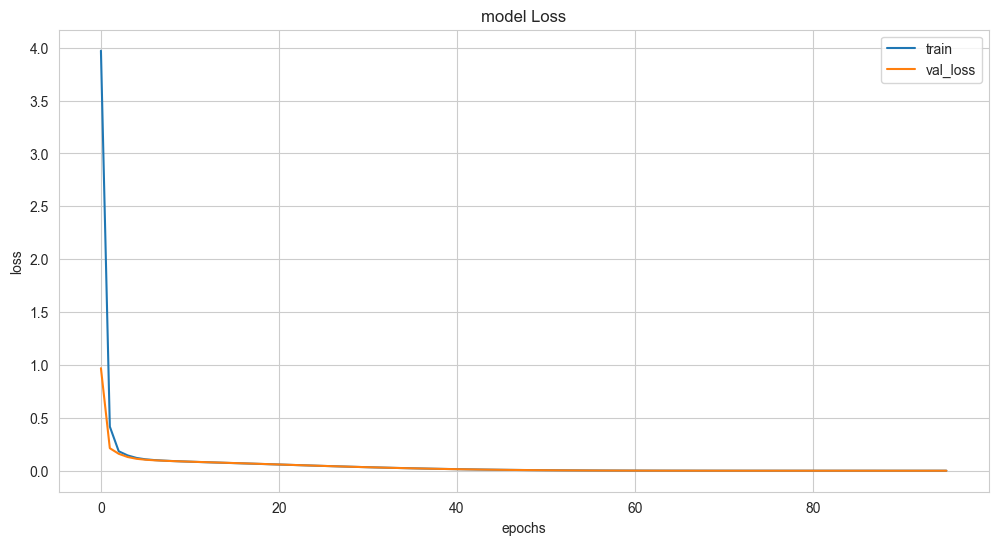

In [36]:
fig = plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model Loss")
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','val_loss'])
plt.show()

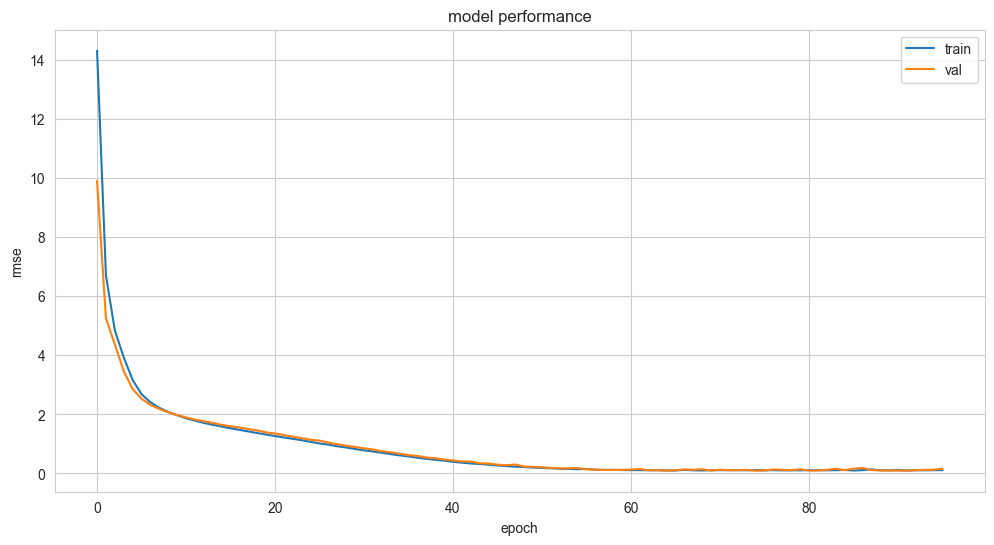

In [37]:
fig = plt.figure(figsize=(12,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [38]:
mlflow.end_run()

2024/10/30 01:13:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run rebellious-lynx-817 at: http://localhost:5000/#/experiments/9/runs/770a6f0740034fc29e07a8761ec77439.
2024/10/30 01:13:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/9.


In [ ]:
# def display_folder_structure(folder, level=0):
#     for item in os.listdir(folder):
#         path = os.path.join(folder, item)
#         print("  " * level + "|-- " + item)
#         if os.path.isdir(path):
#             display_folder_structure(path, level + 1)

In [ ]:
# tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes=True)

### 2.2 Build Model with Search Hyperparameters

In [46]:
def build_model(hp):
    try:
        # Choisissez une valeur optimale pour chaque couche
        dense_1_units = hp.Int('dense_1_units', min_value=32, max_value=128, step=32)
        dense_2_units = hp.Int('dense_2_units', min_value=16, max_value=64, step=32)
        dense_3_units = hp.Int('dense_3_units', min_value=8, max_value=32, step=32)
    
        # Définir le taux de dropout
        dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
        
        # Réglez le taux d'apprentissage de l'optimiseur
        # Choisissez une valeur optimale entre 0,01, 0,001 ou 0,0001
        hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
        # Créer le modèle séquentiel
        model_ = tf.keras.Sequential([
            Input(shape=(52,)),
            Dense(dense_1_units, activation=ReLU()),
            Dense(dense_2_units, activation=ReLU()),
            Dropout(dropout_rate),
            Dense(dense_3_units, activation=ReLU()),
            Dense(1)
        ])
    
        # Compiler le modèle
        model_.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                       loss=MeanAbsoluteError(),
                       metrics=['root_mean_squared_error'])
    
        return model_
    except Exception as e:
        print(f"Error in build_model: {e}")
        raise e

#### 2.1 Définir les paramètres de la grille

#### Définir un Hyperband tuner et rechercher les hyperparamètres

In [47]:
tuner = kt.Hyperband(
    model,
    objective='val_root_mean_squared_error',
    max_epochs=epochs,
    factor=3,
    directory='../vehicle_prediction',  # Dossier pour enregistrer les résultats
    project_name='vehicle_prediction'
)

# Callback pour enregistrer les résultats dans MLflow
mlflow_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: mlflow.log_metrics(logs, step=epoch)
)

# Définir un callback pour arrêter la recherche si la performance ne s'améliore pas
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Lancer la recherche des hyperparamètres
tuner.search(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[stop_early, mlflow_callback])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Enregistrer les meilleurs hyperparamètres dans MLflow
mlflow.log_params({
    'dense_1_units': best_hps.get('dense_1_units'),
    'dense_2_units': best_hps.get('dense_2_units'),
    'dropout_rate': best_hps.get('dropout_rate'),
    'learning_rate': best_hps.get('learning_rate')
})

print(f"""
La recherche d'hyperparamètres est terminée. Le nombre optimal d'unités dans la première
couche densément connectée est {best_hps.get('units')} et le taux d'apprentissage optimal pour l'optimiseur
est {best_hps.get('learning_rate')}.
""")

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x1503c75f0> (of type <class 'keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters'>)

#### 2.2 Entrainement du model

In [ ]:
# Construisez le modèle avec les hyperparamètres optimaux et entraînez-le sur les données de 50 époques
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=1)

In [ ]:
val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

#### Réinstanciez l'hypermodèle et entraînez-le avec le nombre optimal d'époques d'en haut.

In [ ]:
hyper_model = tuner.hypermodel.build(best_hps)
hyper_model = model.fit(train_dataset, epochs=best_epoch, validation_data=val_dataset)

#### Evaluation du Modele

In [ ]:
eval_result = hyper_model.evaluate(test_dataset)
print("[test loss, test loss]:", eval_result)

##### Suivi des métriques personnalisées

In [ ]:
# Suivi des métriques personnalisées
mlflow.log_param("batch_size", batch_size)
mlflow.log_metric("final_loss", model.evaluate(test_dataset))

#### Enregistrer le modèle dans MLflow

In [ ]:
# Enregistrer le modèle dans MLflow
# mlflow.tensorflow.log_model(model, "model")
# mlflow.tensorflow.log_model(hyper_model, "hyper_model")

#### 2.3  Visualisation du Loss

#### 2. 4 Evaluation du model

In [ ]:
test = model.evaluate(X_test, y_test)

In [ ]:
test

#### Prédiction des Valeurs

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred.shape